In [40]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt

from notebooks.data import load_local_blood_transfusion

In [41]:
def split_train_test(X, y, test_ratio=0.3):
    idxs = [i for i in range(len(X))]
    random.shuffle(idxs)
    delim = int(len(X) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return X[train_idxs], y[train_idxs], X[test_idxs], y[test_idxs]

## Zbiór danych
Zbiór danych pochodził z Kaggle https://www.kaggle.com/datasets/mahmudulhaqueshawon/blood-dataset Ma 5 cech, zmienną objaśnianą jest class.

In [42]:
from sklearn.preprocessing import LabelEncoder
def blood():
    X,y = load_local_blood_transfusion()
    X = torch.tensor(X).float()
    X = (X - X.mean()) / X.std()
    y=torch.tensor(y).float().unsqueeze(1)
    return split_train_test(X, y)

x_train, y_train, x_test, y_test = blood()

print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([524, 4])
y_train shape: torch.Size([524, 1])
X_test shape: torch.Size([224, 4])
y_test shape: torch.Size([224, 1])


## Regresja logistyczna bez szyfrowania

Regresja logistyczna to algorytm klasyfikacji binarnej. Parametrami modelu jest wektor wag $w$ oraz bias $b$. Podczas wnioskowania wyznaczana jest wartość prawdopodobieństwa przynależności do jednej z klas $$p(x)=\frac{1}{1+exp(-w^Tx+b)}$$ dla danych wejściowych x. Jeżeli wartość ta jest większa niż 0.5 przydzielana jest etykieta danej klasy, jeśli mniejsza, przydzielana jest etykieta klasy przeciwnej.

Problem regresji logistycznej nie ma rozwiązania analitycznego, stosuje się metody gradientowe, aby wyznaczyć wartości wag. W procesie optymalizacji obliczane są gradienty funkcji straty względem wag i elementu bias, a następnie wartości gradientów po przemnożeniu przez niewielką stałą (learning rate) są odejmowane od wag.
$$\mathcal{L}(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y^{(i)} \log(\sigma(\theta^T x^{(i)})) + (1 - y^{(i)}) \log(1 - \sigma(\theta^T x^{(i)})) \right]$$

In [43]:
class LogisticRegressionModel(torch.nn.Module):

    def __init__(self, n_features):
        super(LogisticRegressionModel, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [44]:
n_features = x_train.shape[1]
model = LogisticRegressionModel(n_features)
optim = torch.optim.SGD(model.parameters(), lr=1)
criterion = torch.nn.BCELoss()

In [45]:
EPOCHS = 20

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    losses = []
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
        losses.append(loss.data)
    return model, losses

s_time=time()
model, losses = train(model, optim, criterion, x_train, y_train)
e_time=time()
t_time=e_time-s_time
print(f"Training time: {t_time}")

Loss at epoch 1: 0.6622087955474854
Loss at epoch 2: 0.6132246255874634
Loss at epoch 3: 0.5820655822753906
Loss at epoch 4: 0.5627376437187195
Loss at epoch 5: 0.5501961708068848
Loss at epoch 6: 0.5418789982795715
Loss at epoch 7: 0.5362681746482849
Loss at epoch 8: 0.5324196815490723
Loss at epoch 9: 0.5297399163246155
Loss at epoch 10: 0.5278491973876953
Loss at epoch 11: 0.5264998078346252
Loss at epoch 12: 0.5255273580551147
Loss at epoch 13: 0.5248205065727234
Loss at epoch 14: 0.5243029594421387
Loss at epoch 15: 0.5239214301109314
Loss at epoch 16: 0.5236387252807617
Loss at epoch 17: 0.5234280824661255
Loss at epoch 18: 0.523270308971405
Loss at epoch 19: 0.5231516361236572
Loss at epoch 20: 0.5230619311332703
Training time: 0.009550333023071289


Text(0, 0.5, 'funkcja straty')

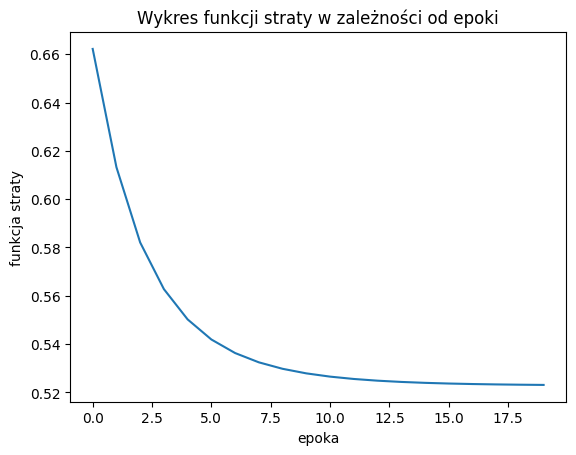

In [46]:
plt.title("Wykres funkcji straty w zależności od epoki")
plt.plot(losses)
plt.xlabel("epoka")
plt.ylabel("funkcja straty")

In [47]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy: {plain_accuracy}")

Accuracy: 0.7678571343421936


## Predykcja na zaszyfrowanych danych

Scenariusz, w którym serwer przechowuje model niezaszyfrowany.
1. Klient przesyła do serwera zaszyfrowane dane oraz klucz publiczny
2. Serwer szyfruje nim model
3. Serwer przeprowadza predykcję używając zaszyfrowanych parametrów modelu i zaszyfrowanych danych
4. Serwer zwraca wyniki predykcji
5. Klient odszyfrowuje wyniki predykcji posługując się kluczem prywatnym

Kluczowe miary to czas szyfrowania danych, czas predykcji oraz różnica pomiędzy wartościami predykcji otrzymanymi dla modelu niezaszyfrowanego i zaszyfrowanego.

Klasa EncryptedLogRegAdapter jest adapterem dla wag wytrenowanego wcześniej na niezaszyfrowanych danych modelu. W konstruktorze tworzy kopię tych danych. Ma metodę encrypt, która szyfruje wagi, decrypt która odszyfrowuje wagi oraz operator wywołania funkcji, który wyznacza przewidywane wartości.

In [48]:
class EncryptedLogRegAdapter:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


eelr = EncryptedLogRegAdapter(model)

In [49]:
# stopień wielomianu używany jako moduł wielomianowy
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# tworzenie kontekstu Tenseal z użyciem schematu CKKS
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** 20
# klucze Galois do rotacji szyfrowanych wektorów oraz do operacji macierzowych
ctx_eval.generate_galois_keys()

In [50]:
s_time = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
e_time = time()
print(f"Test data encryption time: {e_time - s_time}")

Test data encryption time: 0.5326395034790039


In [51]:
## serwer zwraca zaszyfrowany wynik klasyfikacji, a następnie on odszyfrowywany i porównywany z rzeczywistymi etykietami

def encrypted_evaluation(model, enc_x_test, y_test):
    s_time = time()
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out) #zwraca prawdopodobieństwo
        if out<0.5:
            out=0
        else:
            out=1
        if out==y:
            correct += 1

    e_time = time()
    print(f"Evaluation time {e_time-s_time}")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)


encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Plain data accuracy: {plain_accuracy}, Encrypted data accuracy: {encrypted_accuracy}, Difference: {diff_accuracy}")

Evaluation time 0.5860695838928223
Accuracy: 172/224 = 0.7678571428571429
Plain data accuracy: 0.7678571343421936, Encrypted data accuracy: 0.7678571428571429, Difference: 0.0


## Uczenie z szyfrowanym

Scenariusz, w którym serwer otrzymuje zaszyfrowane dane i trenuje model z zaszyfrowanymi parametrami.
1. Klient wysyła zaszyfrowane dane i klucz publiczny do serwera, przesyła także informacje o danych typu rozmiar danych i liczba rekordów
2. Serwer inicjuje model i szyfruje go
3. Następnie w pętli serwer wykonuje kolejne kroki uczenia, podczas których wyznacza funkcję straty, jej gradient względem wag, a następnie uaktualnia wagi
4. Po zakończeniu treningu przesyła do klienta zaszyfrowane wagi lub cały zaszyfrowany model
5. Klient odszyfrowuje wyniki, może ocenić jakość modelu i użyć go do predykcji na własnych danych

W naszym przypadku w trakcie uczenia na zakońćzenie każdej epoki dane są odszyfrowywane i wyznaczana jest wartość metryki accuracy na zbiorze testowym.

Rozwiązanie opracowane na podstawie:
Chen, H., Gilad-Bachrach, R., Han, K. et al. Logistic regression over encrypted data from fully homomorphic encryption. BMC Med Genomics 11 (Suppl 4), 81 (2018). https://doi.org/10.1186/s12920-018-0397-z

1. Zastosowano aproksymację funkcji sigmoidalnej za pomocą odpowiednio dobranego wielomianu, która używana jest jako funkcja aktywacji pojedynczego neuronu w ostatniej warstwie.
2. Gradienty obliczane są jawnie, nie są stosowane obliczenia symboliczne.

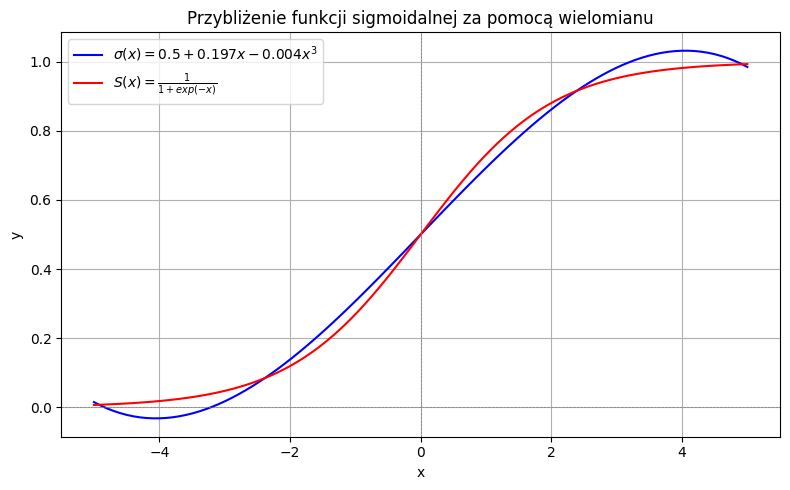

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def sigma(x):
    return 0.5 + 0.197 * x - 0.004 * x**3

x = np.linspace(-5, 5, 100)
y = sigma(x)
y2 = 1/(1+np.exp(-x))

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$\sigma(x) = 0.5 + 0.197x - 0.004x^3$', color='blue')
plt.plot(x, y2, label=r'$S(x) = \frac{1}{1+exp(-x)}$', color='red')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Przybliżenie funkcji sigmoidalnej za pomocą wielomianu')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Funkcja forward wyznacza dla wejścia zakodowanego prawdopodobieństwo klasy ze wzoru $\frac{1}{1+exp(-w^TX)}$, czyli po przemnożeniu wektora przez wagi wykonywane są obliczenia funkcji sigmoidalnej.
Funkcja backward oblicza wartości gradientu ze wzoruów:
$\frac{\partial \mathcal{L}}{\partial w} = x \cdot (\hat{y} - y)$ oraz
$\frac{\partial \mathcal{L}}{\partial b} = \hat{y} - y$

Funkcja update_parameters aktualizuje wagi stosując algorytm gradientu prostego i stosowana jest niewielka regularyzacja.

Funkcja plain_accuracy oblicza accuracy dostając jako parametry dane niezaszyfrowane.

In [53]:
class EncryptedLogisticRegression:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        self.learning_rate=0.1
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLogisticRegression.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        self.weight -= self._delta_w * (self.learning_rate / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (self.learning_rate / self._count)
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        y_pred = (out >= 0.5).int()
        return (y_pred == y_test).float().mean().item()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [54]:
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [55]:
#szyfrowanie zbioru uczącego
s_time = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
e_time = time()
print(f"Train data encryption time {e_time-s_time}")

Train data encryption time 9.297465324401855


In [56]:
from tqdm import tqdm

eelr = EncryptedLogisticRegression(LogisticRegressionModel(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")
accuracies=[]
times = []
for epoch in tqdm(range(EPOCHS)):
    eelr.encrypt(ctx_training)
    s_time = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    e_time = time()
    times.append(e_time - s_time)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    accuracies.append(accuracy)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {sum(times) / len(times)}")
print(f"Final accuracy: {accuracy}")
diff_accuracy = plain_accuracy - accuracy
print(f"Plain data accuracy: {plain_accuracy}, Encrypted data accuracy: {accuracy}, Difference: {diff_accuracy}")

Accuracy at epoch #0 is 0.2366071492433548


  5%|▌         | 1/20 [00:37<11:48, 37.28s/it]

Accuracy at epoch #1 is 0.2366071492433548


 10%|█         | 2/20 [01:16<11:26, 38.14s/it]

Accuracy at epoch #2 is 0.3973214328289032


 15%|█▌        | 3/20 [01:54<10:49, 38.22s/it]

Accuracy at epoch #3 is 0.4642857015132904


 20%|██        | 4/20 [02:30<09:55, 37.22s/it]

Accuracy at epoch #4 is 0.5357142686843872


 25%|██▌       | 5/20 [03:07<09:17, 37.20s/it]

Accuracy at epoch #5 is 0.6116071343421936


 30%|███       | 6/20 [03:43<08:35, 36.79s/it]

Accuracy at epoch #6 is 0.6116071343421936


 35%|███▌      | 7/20 [04:17<07:49, 36.12s/it]

Accuracy at epoch #7 is 0.7589285969734192


 40%|████      | 8/20 [04:52<07:06, 35.58s/it]

Accuracy at epoch #8 is 0.7633928656578064


 45%|████▌     | 9/20 [05:28<06:33, 35.76s/it]

Accuracy at epoch #9 is 0.7633928656578064


 50%|█████     | 10/20 [06:02<05:53, 35.36s/it]

Accuracy at epoch #10 is 0.7633928656578064


 55%|█████▌    | 11/20 [06:37<05:16, 35.19s/it]

Accuracy at epoch #11 is 0.6116071343421936


 60%|██████    | 12/20 [07:11<04:37, 34.72s/it]

Accuracy at epoch #12 is 0.6116071343421936


 65%|██████▌   | 13/20 [07:45<04:00, 34.43s/it]

Accuracy at epoch #13 is 0.6116071343421936


 70%|███████   | 14/20 [08:20<03:28, 34.80s/it]

Accuracy at epoch #14 is 0.7633928656578064


 75%|███████▌  | 15/20 [08:57<02:56, 35.31s/it]

Accuracy at epoch #15 is 0.7633928656578064


 80%|████████  | 16/20 [09:32<02:21, 35.42s/it]

Accuracy at epoch #16 is 0.2366071492433548


 85%|████████▌ | 17/20 [10:07<01:45, 35.15s/it]

Accuracy at epoch #17 is 0.7633928656578064


 90%|█████████ | 18/20 [10:43<01:10, 35.26s/it]

Accuracy at epoch #18 is 0.2366071492433548


 95%|█████████▌| 19/20 [11:17<00:35, 35.04s/it]

Accuracy at epoch #19 is 0.7633928656578064


100%|██████████| 20/20 [11:53<00:00, 35.65s/it]

Accuracy at epoch #20 is 0.2366071492433548

Average time per epoch: 35.63163653612137
Final accuracy: 0.2366071492433548
Plain data accuracy: 0.7678571343421936, Encrypted data accuracy: 0.2366071492433548, Difference: 0.53125


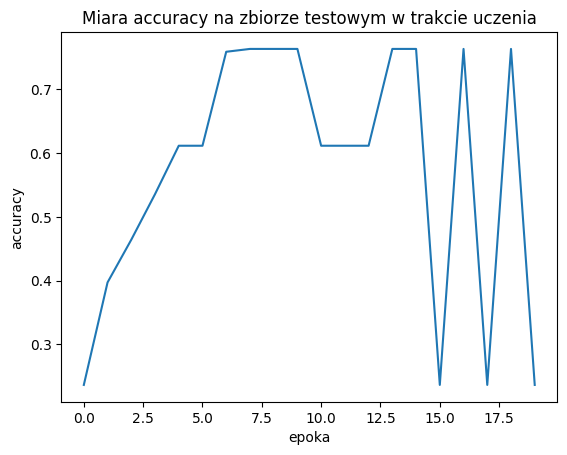

In [57]:
plt.title("Miara accuracy na zbiorze testowym w trakcie uczenia")
plt.xlabel("epoka")
plt.ylabel("accuracy")
plt.plot(accuracies)